# Assignment 2 Notebook
## Regression Model

Root Mean Squared Error: 57.97632116390059
R^2 Score: 0.5495140632944843
Best parameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.9}


Text(50.722222222222214, 0.5, 'alpha')

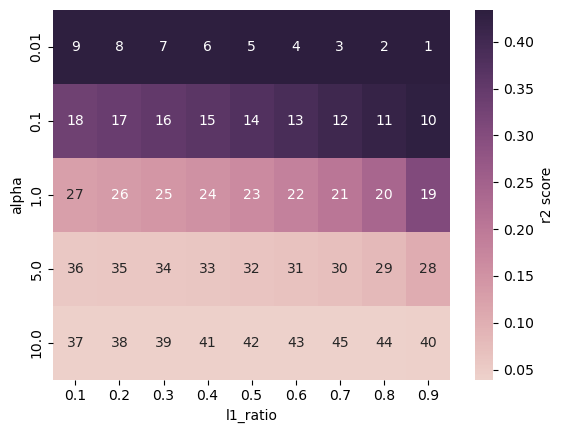

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import root_mean_squared_error, r2_score


# import dataset
heart_disease = pd.read_csv("heart_disease_uci.csv")

# clean data
clean_hd_df = heart_disease.copy()

missing_data = clean_hd_df.isnull().sum() / len(clean_hd_df) # calculate ratio of missing values per column
drop_cols = missing_data[missing_data > 0.3].index # create an index of columns that exceed threshold
clean_hd_df.drop(drop_cols, 
                 axis = 1, 
                 inplace = True
                 ) # drop the columns that exceed threshold

clean_hd_df.dropna(inplace = True) # drop any remaining NAs (mostly categorical/discrete values that wouldn't benefit from imputation)
clean_hd_df.drop_duplicates() # drop duplicate rows

# split into target and features
lin_target = clean_hd_df.copy()[clean_hd_df.columns[5]] # set 'chol' column as target
lin_features = clean_hd_df.copy().drop("chol", axis = 1) # set all other columns as features

for col in lin_features.columns:
    if lin_features[col].dtype == 'object':
        lin_features = pd.concat([lin_features, 
                                  pd.get_dummies(lin_features[col], 
                                                 prefix = col)], 
                                 axis = 1
                                 ) # one-hot encode categorical variables
        lin_features.drop(col, 
                          axis = 1, 
                          inplace = True
                          )

# split data into training and testing
lin_x_train, lin_x_test, lin_y_train, lin_y_test = train_test_split(lin_features, 
                                                                    lin_target, 
                                                                    test_size = 0.15, 
                                                                    random_state = 27
                                                                    )

# train model
elnet_reg = ElasticNet(alpha = 0.01, 
                       l1_ratio = 0.9, 
                       max_iter = 5000
                       )
elnet_reg.fit(lin_x_train, lin_y_train)

# predict on test data
lin_y_pred = elnet_reg.predict(lin_x_test)

# evaluate model
rmse = root_mean_squared_error(lin_y_test, lin_y_pred)
r2 = r2_score(lin_y_test, lin_y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

# determine best parameters for alpha and l1 ratio 
# define parameter grid
param_grid_en = {
    'alpha' : [0.01, 0.1, 1, 5, 10], 
    'l1_ratio' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }

# perform grid search
grid_search_en = GridSearchCV(ElasticNet(max_iter = 5000), 
                              param_grid_en, 
                              cv = 5
                              )
grid_search_en.fit(lin_x_train, lin_y_train)

print(f"Best parameters for ElasticNet: {grid_search_en.best_params_}")

# store results of parameter search in variables
param_scores = pd.DataFrame(grid_search_en.cv_results_['mean_test_score'])
param_scores_reshaped = param_scores.values.reshape(5, 9) # change shape of df from one col with all values to 9 cols (l1) and 5 rows (alpha)
en_param_scores = pd.DataFrame(param_scores_reshaped, 
                               index = param_grid_en['alpha'], 
                               columns = param_grid_en['l1_ratio']
                               )
en_param_ranks = pd.DataFrame(grid_search_en.cv_results_['rank_test_score']).values.reshape(5, 9)

# display results of parameter search with heatmap
sns.heatmap(en_param_scores, 
            cmap = sns.cubehelix_palette(as_cmap=True), 
            annot = en_param_ranks, 
            cbar_kws = {'label' : 'r2 score'}
            )
plt.xlabel('l1_ratio')
plt.ylabel('alpha')


## Classification Model

Accuracy score: 0.8558558558558559
F1 score: 0.8805970149253731


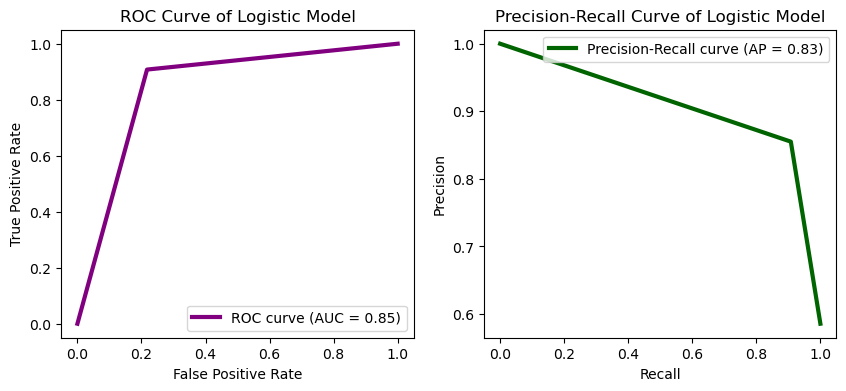

Accuracy score: 0.6216216216216216
F1 score: 0.6818181818181818


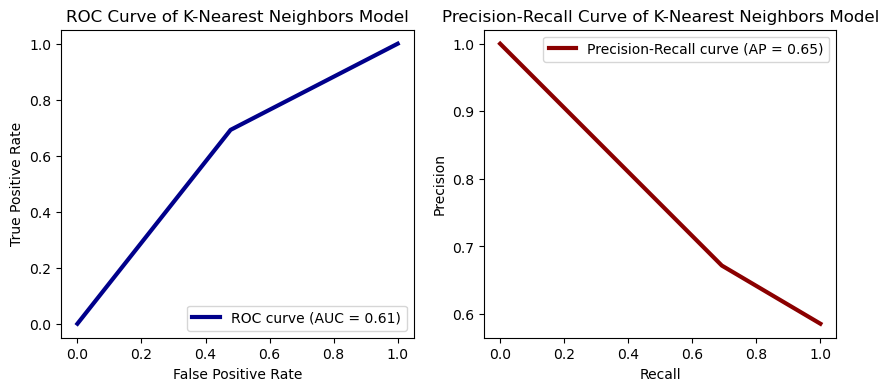

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score

# copy dataset
clean_hd_df2 = heart_disease.copy()

# clean data
missing_data2 = clean_hd_df2.isnull().sum() / len(clean_hd_df2) # calculate ratio of missing values per column
drop_cols2 = missing_data2[missing_data2 > 0.3].index # create an index of columns that exceed threshold
clean_hd_df2.drop(drop_cols, 
                  axis = 1, 
                  inplace = True
                  ) # drop columns that exceed threshold

clean_hd_df2.dropna(inplace = True) # drop remaining NA values
clean_hd_df2.drop_duplicates() # drop duplicate rows

# split into target and features
log_target = clean_hd_df2.copy()[clean_hd_df2.columns[11]] # set 'num' as target
log_features = clean_hd_df2.copy().drop("num", axis = 1) # set all other columns as features

log_target = log_target.apply(lambda x: 1 if x != 0 else 0) # num has values 0-4; replace all non-zeros to 1 for binary classification (0 = absent; 1 = present)

for col in log_features.columns:
    if log_features[col].dtype == 'object':
        log_features = pd.concat([log_features, 
                                  pd.get_dummies(log_features[col], 
                                                 prefix = col)], 
                                 axis = 1
                                 ) # one-hot encode categorical variables
        log_features.drop(col, 
                          axis = 1, 
                          inplace = True
                          )

# split data into training and testing
bin_x_train, bin_x_test, bin_y_train, bin_y_test = train_test_split(log_features, 
                                                                    log_target, 
                                                                    test_size = 0.15, 
                                                                    random_state = 27
                                                                    )

################################################ Logistic Model ################################################
# train model
log_reg = LogisticRegression(penalty = 'l1', 
                             solver = 'liblinear'
                             )
log_reg.fit(bin_x_train, bin_y_train)

# predict on test data
log_y_pred = log_reg.predict(bin_x_test)

# evaluate the model
# AUROC
log_fpr, log_tpr, th = roc_curve(bin_y_test, log_y_pred)
log_auroc = auc(log_fpr, log_tpr)
# AUPRC
log_precision, log_recall, th2 = precision_recall_curve(bin_y_test, log_y_pred)
log_average_precision = average_precision_score(bin_y_test, log_y_pred)
# accuracy and f1 scores
log_acc = accuracy_score(bin_y_test, log_y_pred)
log_f1 = f1_score(bin_y_test, log_y_pred)

print(f'Accuracy score: {log_acc}')
print(f'F1 score: {log_f1}')

# plot AUROC and AUPRC
log_fig, log_axes = plt.subplots(1, 2, figsize = (10, 4))
# AUROC
log_axes[0].plot(log_fpr, 
                 log_tpr, 
                 color = 'purple', 
                 lw = 3, 
                 label = 'ROC curve (AUC = %0.2f)' % log_auroc
                 )
log_axes[0].set_xlabel('False Positive Rate')
log_axes[0].set_ylabel('True Positive Rate')
log_axes[0].set_title('ROC Curve of Logistic Model')
log_axes[0].legend(loc = 'lower right')
# AUPRC
log_axes[1].plot(log_recall, 
                 log_precision, 
                 color = 'darkgreen', 
                 lw = 3, 
                 label = 'Precision-Recall curve (AP = %0.2f)' % log_average_precision
                 )
log_axes[1].set_xlabel('Recall')
log_axes[1].set_ylabel('Precision')
log_axes[1].set_title('Precision-Recall Curve of Logistic Model')
log_axes[1].legend(loc = 'upper right')

plt.show()

################################################ K-NN Model ################################################
# train model
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(bin_x_train, bin_y_train)

# predict on test data
knn_y_pred = knn.predict(bin_x_test)

# evaluate model
# AUROC
knn_fpr, knn_tpr, _ = roc_curve(bin_y_test, knn_y_pred)
knn_auroc = auc(knn_fpr, knn_tpr)
# AUPRC
knn_precision, knn_recall, th3 = precision_recall_curve(bin_y_test, knn_y_pred)
knn_average_precision = average_precision_score(bin_y_test, knn_y_pred)
# accuracy and f1 scores
knn_acc = accuracy_score(bin_y_test, knn_y_pred)
knn_f1 = f1_score(bin_y_test, knn_y_pred)

print(f'Accuracy score: {knn_acc}')
print(f'F1 score: {knn_f1}')

# plot AUROC and AUPRC
knn_fig, knn_axes = plt.subplots(1, 2, figsize = (10, 4))
# AUROC
knn_axes[0].plot(knn_fpr, 
                 knn_tpr, 
                 color = 'darkblue', 
                 lw = 3, 
                 label = 'ROC curve (AUC = %0.2f)' % knn_auroc
                 )
knn_axes[0].set_xlabel('False Positive Rate')
knn_axes[0].set_ylabel('True Positive Rate')
knn_axes[0].set_title('ROC Curve of K-Nearest Neighbors Model')
knn_axes[0].legend(loc = 'lower right')
# AUPRC
knn_axes[1].plot(knn_recall, 
                 knn_precision, 
                 color = 'darkred', 
                 lw = 3, 
                 label = 'Precision-Recall curve (AP = %0.2f)' % knn_average_precision
                 )
knn_axes[1].set_xlabel('Recall')
knn_axes[1].set_ylabel('Precision')
knn_axes[1].set_title('Precision-Recall Curve of K-Nearest Neighbors Model')
knn_axes[1].legend(loc = 'upper right')

plt.show()